In [12]:
!pip -q install pyyaml gdown

In [13]:
from pathlib import Path
import shutil
import yaml
from collections import Counter
import zipfile
import os

In [14]:
DATASET_ROOT=Path(r"C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\OI-PBC-Dataset-main-original 12 classes\Dataset\PBC-YOLO-811")
OUTPUT_ROOT= Path(r"C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes")

In [15]:
CLASS_MAPPING = {
    0: 0,  
    1: 0,  
    2: 0,  
    3: 1,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 2,
    9: 0,
    10: 1,
    11: 0,
}

NEW_CLASS_NAMES = ['WBC', 'RBC', 'Platelets']

print("📋 Class Mapping:")
print("  Original → New")
for old_cls, new_cls in CLASS_MAPPING.items():
    print(f"  Class {old_cls} → {new_cls} ({NEW_CLASS_NAMES[new_cls]})")

📋 Class Mapping:
  Original → New
  Class 0 → 0 (WBC)
  Class 1 → 0 (WBC)
  Class 2 → 0 (WBC)
  Class 3 → 1 (RBC)
  Class 4 → 0 (WBC)
  Class 5 → 0 (WBC)
  Class 6 → 0 (WBC)
  Class 7 → 0 (WBC)
  Class 8 → 2 (Platelets)
  Class 9 → 0 (WBC)
  Class 10 → 1 (RBC)
  Class 11 → 0 (WBC)


In [16]:
def convert_label_file(input_path, output_path, class_mapping):
    with open(input_path, 'r') as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            old_class = int(parts[0])
            new_class = class_mapping.get(old_class, old_class)
            new_line = f"{new_class} {' '.join(parts[1:])}\n"
            new_lines.append(new_line)
    
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        f.writelines(new_lines)

In [17]:
print("📁 Creating output directory structure...")

for split in ['train', 'val', 'test']:
    (OUTPUT_ROOT / 'images' / split).mkdir(parents=True, exist_ok=True)
    (OUTPUT_ROOT / 'labels' / split).mkdir(parents=True, exist_ok=True)

print(f"✅ Output directory created at: {OUTPUT_ROOT}")

📁 Creating output directory structure...
✅ Output directory created at: C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes


In [18]:
print("\n🔄 Converting dataset...")
print("="*60)

stats = Counter()

for split in ['train', 'val', 'test']:
    print(f"\n📂 Processing {split} split...")
    
    input_img_dir = DATASET_ROOT / 'images' / split
    input_lbl_dir = DATASET_ROOT / 'labels' / split
    
    output_img_dir = OUTPUT_ROOT / 'images' / split
    output_lbl_dir = OUTPUT_ROOT / 'labels' / split
    
    image_files = list(input_img_dir.glob('*.*'))
    
    for img_file in image_files:
        # Copy image
        shutil.copy2(img_file, output_img_dir / img_file.name)
        
        # Convert label
        label_file = input_lbl_dir / f"{img_file.stem}.txt"
        if label_file.exists():
            output_label = output_lbl_dir / label_file.name
            convert_label_file(label_file, output_label, CLASS_MAPPING)
            stats[split] += 1
    
    print(f"   ✅ Processed {len(image_files)} images")

print("\n" + "="*60)
print("📊 Conversion Summary:")
for split, count in stats.items():
    print(f"   {split}: {count} files")
print("="*60)


🔄 Converting dataset...

📂 Processing train split...
   ✅ Processed 13498 images

📂 Processing val split...
   ✅ Processed 1687 images

📂 Processing test split...
   ✅ Processed 1688 images

📊 Conversion Summary:
   train: 13498 files
   val: 1687 files
   test: 1688 files


In [19]:
print("\n📝 Creating data.yaml...")

yaml_content = {
    'path': str(OUTPUT_ROOT.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 3,
    'names': NEW_CLASS_NAMES
}

yaml_path = OUTPUT_ROOT / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"✅ data.yaml created at: {yaml_path}")
print("\n📄 Content:")
print(yaml.dump(yaml_content, default_flow_style=False))


📝 Creating data.yaml...
✅ data.yaml created at: C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes\data.yaml

📄 Content:
names:
- WBC
- RBC
- Platelets
nc: 3
path: C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2
  3 classes
test: images/test
train: images/train
val: images/val



In [20]:
# Verify conversion
print("\n🔍 Verifying conversion...")
print("="*60)

for split in ['train', 'val', 'test']:
    label_dir = OUTPUT_ROOT / 'labels' / split
    if not label_dir.exists():
        continue
        
    class_counts = Counter()
    total_boxes = 0
    
    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1
                    total_boxes += 1
    
    print(f"\n📂 {split.upper()}:")
    print(f"   Total boxes: {total_boxes}")
    for class_id in sorted(class_counts.keys()):
        class_name = NEW_CLASS_NAMES[class_id] if class_id < len(NEW_CLASS_NAMES) else f"Unknown-{class_id}"
        count = class_counts[class_id]
        percentage = (count / total_boxes) * 100 if total_boxes > 0 else 0
        print(f"   Class {class_id} ({class_name}): {count} ({percentage:.1f}%)")

print("\n" + "="*60)
print("✅ CONVERSION COMPLETE!")
print(f"📁 Output: {OUTPUT_ROOT.absolute()}")
print("="*60)


🔍 Verifying conversion...

📂 TRAIN:
   Total boxes: 238652
   Class 0 (WBC): 10462 (4.4%)
   Class 1 (RBC): 216469 (90.7%)
   Class 2 (Platelets): 11721 (4.9%)

📂 VAL:
   Total boxes: 29549
   Class 0 (WBC): 1347 (4.6%)
   Class 1 (RBC): 26824 (90.8%)
   Class 2 (Platelets): 1378 (4.7%)

📂 TEST:
   Total boxes: 29792
   Class 0 (WBC): 1327 (4.5%)
   Class 1 (RBC): 26948 (90.5%)
   Class 2 (Platelets): 1517 (5.1%)

✅ CONVERSION COMPLETE!
📁 Output: C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes


Vou gerar 100 pares (OLD vs NEW) para comparação.
✅ Guardado em: C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes\label_compare
✅ Exemplo: C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds2\dataset\ds2 3 classes\label_compare\001_train_EO_589782.jpg


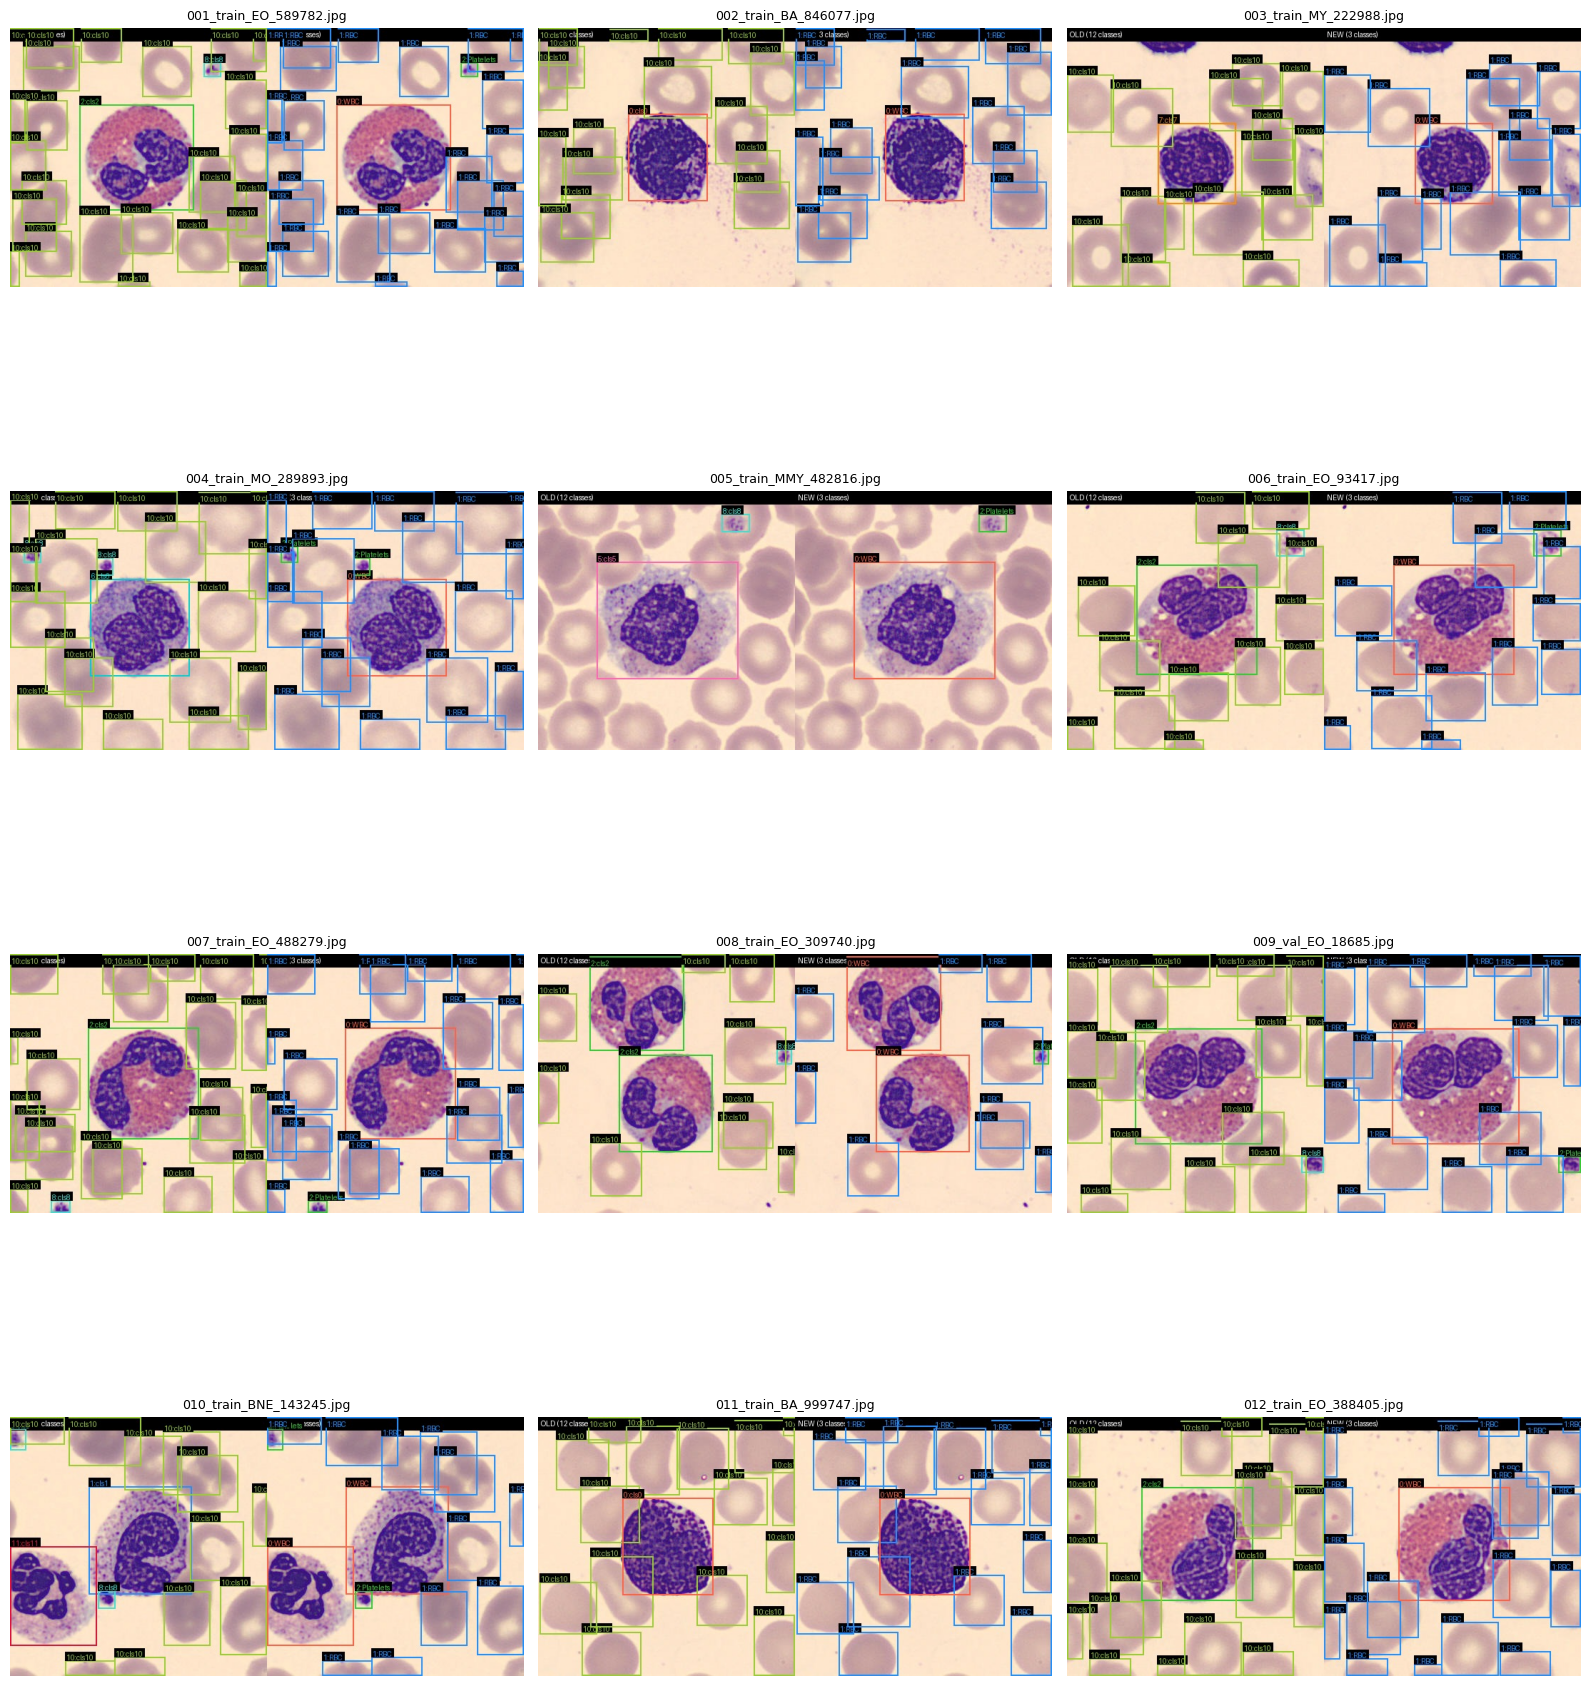

In [22]:
from pathlib import Path
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


N = 100
SEED = 42
SPLITS = ["train", "val", "test"]

random.seed(SEED)
    OLD_CLASS_NAMES
except NameError:
    OLD_CLASS_NAMES = [f"cls{i}" for i in range(12)]

NEW_CLASS_NAMES = NEW_CLASS_NAMES if "NEW_CLASS_NAMES" in globals() else ["WBC", "RBC", "Platelets"]


def read_yolo_labels(label_path: Path):
    """Return list of (cls, x, y, w, h) in YOLO normalized format."""
    if (label_path is None) or (not label_path.exists()):
        return []
    boxes = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            c, x, y, w, h = parts
            boxes.append((int(c), float(x), float(y), float(w), float(h)))
    return boxes

def color_for_class(c: int):
    palette = [
        (255,  99,  71), ( 30, 144, 255), ( 50, 205,  50), (255, 215,   0),
        (138,  43, 226), (255, 105, 180), (  0, 206, 209), (255, 140,   0),
        ( 64, 224, 208), (199,  21, 133), (154, 205,  50), (220,  20,  60),
    ]
    return palette[c % len(palette)]

from PIL import Image, ImageDraw, ImageFont

def draw_boxes(img: Image.Image, boxes, class_names, title=None):
    out = img.copy().convert("RGB")
    draw = ImageDraw.Draw(out)
    font = ImageFont.load_default()

    W, H = out.size

    if title:
        bar_h = 18
        draw.rectangle([0, 0, W, bar_h], fill=(0, 0, 0))
        draw.text((4, 3), title, fill=(255, 255, 255), font=font)

    for (c, x, y, w, h) in boxes:
        xc, yc = x * W, y * H
        bw, bh = w * W, h * H
        x1, y1 = xc - bw / 2, yc - bh / 2
        x2, y2 = xc + bw / 2, yc + bh / 2
        x1 = max(0, min(W - 1, x1))
        y1 = max(0, min(H - 1, y1))
        x2 = max(0, min(W - 1, x2))
        y2 = max(0, min(H - 1, y2))
        if x2 < x1: x1, x2 = x2, x1
        if y2 < y1: y1, y2 = y2, y1

        col = color_for_class(c)
        draw.rectangle([int(x1), int(y1), int(x2), int(y2)], outline=col, width=2)

        name = class_names[c] if (0 <= c < len(class_names)) else f"cls{c}"
        txt = f"{c}:{name}"

        bbox = draw.textbbox((0, 0), txt, font=font)
        tw = bbox[2] - bbox[0]
        th = bbox[3] - bbox[1]
        pad = 2
        x0 = int(x1)
        x1b = int(min(W - 1, x0 + tw + 2 * pad))

        y0 = int(y1 - th - 2 * pad)
        y1b = int(y1)

        if y0 < 0:  
            y0 = int(min(H - 1, y1 + pad))
            y1b = int(min(H - 1, y0 + th + 2 * pad))

        if y1b < y0:
            y0, y1b = y1b, y0

        draw.rectangle([x0, y0, x1b, y1b], fill=(0, 0, 0))
        draw.text((x0 + pad, y0 + pad), txt, fill=col, font=font)

    return out


def hstack(a: Image.Image, b: Image.Image):
    """Concatenate two images horizontally (same height)."""
    a = a.convert("RGB")
    b = b.convert("RGB")
    if a.size != b.size:
        b = b.resize(a.size)
    W, H = a.size
    out = Image.new("RGB", (W * 2, H))
    out.paste(a, (0, 0))
    out.paste(b, (W, 0))
    return out

all_imgs = []
for split in SPLITS:
    img_dir = OUTPUT_ROOT / "images" / split
    if img_dir.exists():
        all_imgs += sorted([p for p in img_dir.glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]])

if len(all_imgs) == 0:
    raise RuntimeError("Não encontrei imagens em OUTPUT_ROOT/images/(train|val|test). Confirma os paths DATASET_ROOT e OUTPUT_ROOT.")

sample = random.sample(all_imgs, k=min(N, len(all_imgs)))
print(f"Vou gerar {len(sample)} pares (OLD vs NEW) para comparação.")


out_dir = OUTPUT_ROOT / "label_compare"
out_dir.mkdir(parents=True, exist_ok=True)

saved = []
for i, img_path in enumerate(sample, 1):
    split = img_path.parent.name
    stem = img_path.stem
    old_img_path = DATASET_ROOT / "images" / split / img_path.name
    if old_img_path.exists():
        base_img_path = old_img_path
    else:
        base_img_path = img_path

    old_lbl = DATASET_ROOT / "labels" / split / f"{stem}.txt"
    new_lbl = OUTPUT_ROOT  / "labels" / split / f"{stem}.txt"

    img = Image.open(base_img_path).convert("RGB")
    old_boxes = read_yolo_labels(old_lbl)
    new_boxes = read_yolo_labels(new_lbl)

    img_old = draw_boxes(img, old_boxes, OLD_CLASS_NAMES, title="OLD (12 classes)")
    img_new = draw_boxes(img, new_boxes, NEW_CLASS_NAMES, title="NEW (3 classes)")

    comp = hstack(img_old, img_new)

    out_path = out_dir / f"{i:03d}_{split}_{stem}.jpg"
    comp.save(out_path, quality=92)
    saved.append(out_path)

print(f"✅ Guardado em: {out_dir}")
print(f"✅ Exemplo: {saved[0] if saved else '—'}")


show_k = min(12, len(saved))
cols = 3
rows = (show_k + cols - 1) // cols
plt.figure(figsize=(16, 5 * rows))
for j in range(show_k):
    im = Image.open(saved[j])
    ax = plt.subplot(rows, cols, j + 1)
    ax.imshow(im)
    ax.set_title(saved[j].name, fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()
